# MIE1624 Tutorial 3 - Multiclass Classification and Evaluation Metrics

In this tutorial, we will cover how to train a multiclass classifier using logistic regression, and various evaluation metrics, like accuracy, precision, recall, and f1-score. We also see two types of evaluation plots: the ROC curve and decision boundary curves.

#### Install necessary libraries
First we will install the necessary libraries to run the following code.

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn

## Importing libraries
Then we will import the libraries we need to run the following code.

In [2]:
import numpy as np
import pandas as pd

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Show plots inline
%matplotlib inline

## Data: Iris Dataset
For this tutorial, we will use the popular iris dataset

### Load in data

In [3]:
irisDF = sns.load_dataset('iris')

In [4]:
irisDF.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
irisDF.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
irisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [7]:
irisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In this dataset, there are 150 samples, and the type of the species column is object. We will convert this to a category so we can use `.cat` functionalities (Functions specific to categories).

In [8]:
irisDF['species'] = irisDF['species'].astype('category')

The values are unchanged:

In [9]:
irisDF['species'].head()

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: species, dtype: category
Categories (3, object): [setosa, versicolor, virginica]

We can view all the types using `.cat.categories`:

In [10]:
irisDF['species'].cat.categories

Index(['setosa', 'versicolor', 'virginica'], dtype='object')

We can also get the data coded numerically using `.cat.codes`

In [11]:
irisDF['species'].cat.codes.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

## Description

In this datasets consists of 3 different type of iries' (Setosa, Versicolor, and Virginica) petal and sepal length and width.

In this notebook, we will train a classifier to use these measurements to try to predict the type of iris.

There are 3 classes: setosa, versicolor, and virginica, and 4 features: sepal_length, sepal_width, petal_length, and petal_width.

In [12]:
print('Features:',irisDF.columns[:4].values)

Features: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width']


In [13]:
print('Targets:',irisDF['species'].cat.categories.values)

Targets: ['setosa' 'versicolor' 'virginica']


In [14]:
print ('Value counts:')
irisDF['species'].value_counts()

Value counts:


virginica     50
versicolor    50
setosa        50
Name: species, dtype: int64

Note that the sample distribution is even. There are equal amount of samples for each class.

## Data Visualization

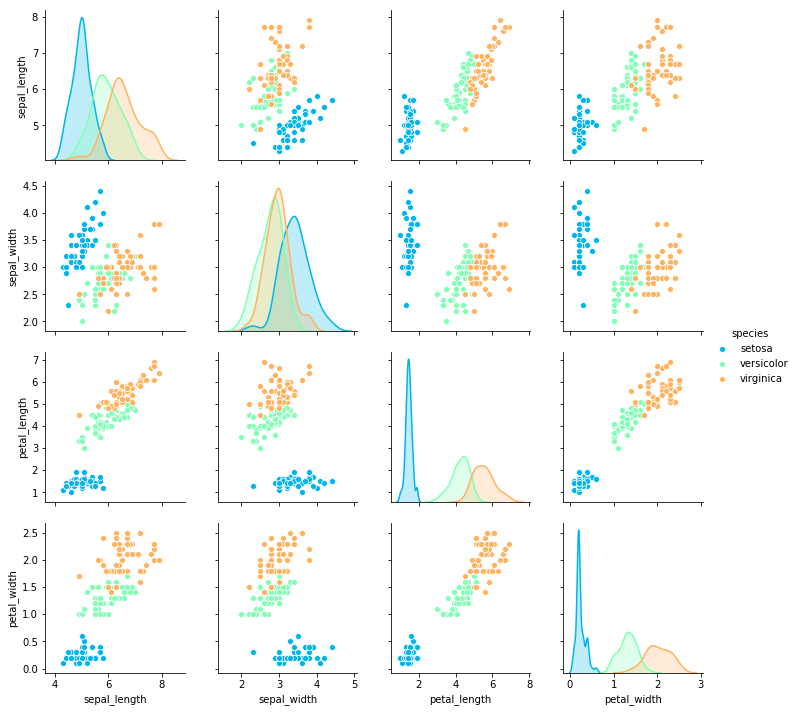

In [15]:
sns.pairplot(irisDF, hue='species',palette='rainbow')

From the above you can see that the setosa is fairly simple to classify. E.g., if petal_length < 2.5, it's very likely it is a setosa iris. 

You also see that for the other two iris. The decision boundary is fairly linear so linear model like logistic regression should work well.

### Principal Component Analysis

Principal Component Analysis (PCA) is a dimension reduction technique. It decomposes your data into principal components where each principal component tries to explain as much variance left as possible in your data, in decending order. E.g., PC1 will explain as much variance as possible, PC2 will try to explain as much of the variance left as possible after the PC1 rotation is applied and so on. Each principal component is a combination of your existing components.

This will allow us to visualize this higher dimensional data in a lower dimensional space.

### Normalize data
Here we will scale the data so that they are within the same range. For PCA to work correctly and find the right covariance amongst all your features you need to scale the data so that they are within the same range. This will keep one feature from contributing more to the final components.

The StandardScaler class from sklearn will remove the mean and scale the data so the have unit variance.

In [16]:
irisDF.drop('species',axis=1).values[0:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

Here are the means/std per feature.

In [17]:
irisDF.drop('species',axis=1).values.mean(axis=0)

array([5.84333333, 3.05733333, 3.758     , 1.19933333])

In [18]:
irisDF.drop('species',axis=1).values.std(axis=0)

array([0.82530129, 0.43441097, 1.75940407, 0.75969263])

Here, we fit the scaler.

In [19]:
scaler = StandardScaler()
scaler.fit(irisDF.drop('species',axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
scaled_data = scaler.transform(irisDF.drop('species',axis=1))
scaled_data[0:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

Here are the new means and standard deviation per feature.

In [21]:
scaled_data.mean(axis=0)

array([-4.73695157e-16, -7.81597009e-16, -4.26325641e-16, -4.73695157e-16])

In [22]:
scaled_data.std(axis=0)

array([1., 1., 1., 1.])

### PCA
Now we will fit PCA model to the data. We will specify n_components=2, because we only want the first 2 principal components.

In [23]:
pca = PCA(n_components=2)
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
scaled_data.shape

(150, 4)

In [25]:
x_pca = pca.transform(scaled_data)

In [26]:
x_pca.shape

(150, 2)

#### Explained Variance

In [27]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762])

In [28]:
pca.explained_variance_ratio_.sum()*100

95.81320720000164

From above you can see that our first 2 principal components explain 95.8% of the variance in our data. We can get higher variance explained by increasing the number of principal components to a maximum of 100% with n_components = n_features.

#### Plotting the principal components

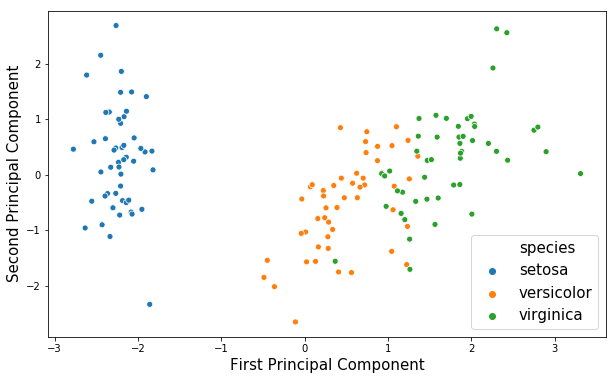

In [29]:
fig = plt.figure(figsize=(10,6))
sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=irisDF['species'])
plt.xlabel('First Principal Component', fontsize=15)
plt.ylabel('Second Principal Component', fontsize=15)
plt.legend(fontsize=15)

From this plot, again you see setosa is easy to classify. Versicolor and virginica can also reasonably be split with a linear decision boundary so Logistic Regression would likely be a good model to use to classify this dataset.

## Logistic Regression

Now we will train a logistic regression model on this dataset by splitting it into a training and testing set. The steps for fitting a binary logistic classifier and a multi-class logistic classifier are the same.

### Split dataset
First we will split the dataset into features and targets.

In [30]:
X = irisDF.drop('species',axis=1)
y = irisDF['species']

### Create training and testing sets
We will use train_test_split with test size of 0.3 to put 70% of our data into training, and 30% into testing. The random_state is set so the results are repeatable.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

### Train model
Now we will create and train the model.

In [32]:
model = LogisticRegression()

In [33]:
model.fit(X_train,y_train)

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Make predictions

### Single sample

Lets make a prediction on the following sample:

In [34]:
idx = 90
irisDF.iloc[idx]

sepal_length           5.5
sepal_width            2.6
petal_length           4.4
petal_width            1.2
species         versicolor
Name: 90, dtype: object

In [35]:
single_x_test = [irisDF.iloc[idx].drop('species').tolist()]
single_y_test = irisDF.iloc[idx]['species']

In [36]:
single_prediction = model.predict(single_x_test)

print('For this sample, our model predicted %s and it was actually %s' % (single_prediction[0], single_y_test))

For this sample, our model predicted versicolor and it was actually versicolor


You can change the `idx` number and re-run the cells to make predictions on different samples within the dataframe

### Entire test set

In [37]:
predictions = model.predict(X_test)

We can create a dataframe to see these in table form:

In [38]:
resultsDF = pd.DataFrame({
        'true':y_test,
        'predicted':predictions
    })
resultsDF.head()

,true,predicted
33,setosa,setosa
16,setosa,setosa
43,setosa,setosa
129,virginica,virginica
50,versicolor,versicolor


## Metrics

### Basic Terminology
- **True Postives (TP)**: Predict that it is true, and it is actually true
- **False Positive (FP)**: Predict that it is true, but it is actually false
- **False Negative (FN)**: Predict that it is false, but it is actually true
- **True Negative (TN)**: Predict that it is false, and it is actually false

These terms are not well-defined in the multi-class case. Typically, we need to use one vs. all style classifiers so that the model is fitted with one class as the positive class and the remainder as the negative class. We will get back to this later in the tutorial. First we will go over some universal metrics:

### Accuracy

In binary classification, accuracy is defined as:

$$accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

In multi-class classification, TN, FP and FN are not well defined as there are three classes. 
Accuracy in this case is:

$$accuracy = \frac{correct\ predictions}{samples}$$

We can evaluate the accuracy using the `accuracy_score` function from `sklearn.metrics`:

In [39]:
print('Accuracy: %.2f%%' % (accuracy_score(predictions,y_test)*100))

Accuracy: 95.56%


### Recall, Precision, and F1-Score
We can view this metrics by running a classification_report on the results of the model.

These metrics are more on a per-class basis.

In [40]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.90      0.95        20
   virginica       0.86      1.00      0.92        12

   micro avg       0.96      0.96      0.96        45
   macro avg       0.95      0.97      0.96        45
weighted avg       0.96      0.96      0.96        45



**Support** defines the number of relevant samples in the testing set. E.g., our testing set has 13 setosa samples, 20 versicolor samples, and 12 viriginica samples, for a total of 45, which is 30% of our data (150 total samples). We could get an even split of data by adding the `stratify=y` argument to the `train_test_split` function.

#### Recall
For one class, how many of the class samples did the model find in the testing set and correctly identify:

E.g, for versicolour: Of the 20 versicolour samples, we found and correctly identified 90% of them, so 18 samples, were found and correctly identified.

$$Recall = \frac{TP}{TP + FN}$$

In [41]:
print ('Missed versicolour samples')
resultsDF[(resultsDF['true'] == 'versicolor') & (resultsDF['predicted'] != 'versicolor')]

Missed versicolour samples


,true,predicted
77,versicolor,virginica
66,versicolor,virginica


#### Precision 

For one class, of all the samples predicted as that class, how many were correct predictions:

E.g, for virginica, we have perfect recall so our model found and made correct predictions on all virginica samples but it also has less than perfect percision because it predicted samples belonging to other classes as virginica.

There were are total of 12 virginica predictions: 12/0.86 = 14,
12 of which were TP so 2 were incorrect predictions (FP).

$$Precision = \frac{TP}{TP + FP}$$



In [42]:
print ('Mispredicted virginica samples')
resultsDF[(resultsDF['true'] != 'virginica') & (resultsDF['predicted'] == 'virginica')]

Mispredicted virginica samples


,true,predicted
77,versicolor,virginica
66,versicolor,virginica


#### F1-Score

When you want to take both recall and precision into consideration, you could use the F1-score.

The F1-score, or F-measure, is a metric that considers both precision and recall. It is defined as:

$$F1-score = \frac{2}{\frac{1}{R1ecall} + \frac{1}{Precision}}$$

### Confusion Matrix
The confusion matrix allows you to see the numerical breakdown of the predictions by class:

In [43]:
cm = confusion_matrix(predictions,y_test, labels=y.cat.categories)
print(cm)

[[13  0  0]
 [ 0 18  0]
 [ 0  2 12]]


To attach labels, we can view it as a dataframe:

In [44]:
cmDF = pd.DataFrame()

for i, row in enumerate(y.cat.categories):
    temp = {}
    for j, col in enumerate(y.cat.categories): 
        temp[col]=cm[i,j]
    cmDF = cmDF.append(pd.DataFrame.from_dict({row:temp}, orient='index'))

print(cmDF)

            setosa  versicolor  virginica
setosa          13           0          0
versicolor       0          18          0
virginica        0           2         12


We can also add a heatmap to better visualize it

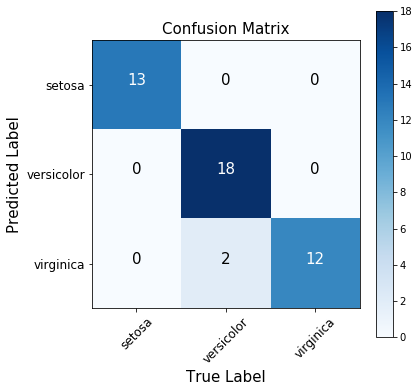

In [45]:
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), rotation=45, fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 5:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)


## ROC Curve

The Receiver Operating Characteristic (ROC) curve is a graphical way of showing the predictive capacity of a binary classifier. It is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR).

### True Positive Rate
TPR is another name for recall and is for the probability of detection. If there is a true positive, how likely would the model find it. 
$$TPR = Recall = \frac{TP}{TP + FN}$$

## False Positive Rate
FPR represents the probability of false alarms, i.e, if there is a true detection, how likely is it that it would be false.

$$FPR = \frac{FP}{TP + TN}$$

A ROC curve plots TPR and FPR at different classification thresholds. By modifying the threshold, we can change the number of items classifies as true positive or false positive.

Again, as explained before these metrics are not well-defined in the multi-class case so we will use a OneVsRestClassifier to set one class as true and the rest as false for each class.

First we will binarize the labels as this is required for the OneVsRestClassifier to work.

In [46]:
bin_y = label_binarize(y, classes=y.cat.categories)
bin_y[0:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

We will split the data again with this new binarized y.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, bin_y, test_size=0.3, random_state=101)

We will now train a OneVsRestClassifier with LogisticRegression

In [48]:
model = OneVsRestClassifier(LogisticRegression())
model.fit(X_train, y_train)

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

We will get the prediction probabilities for all classes, and find FPR, TPR, and AUC for each class.

In [49]:
y_score = model.decision_function(X_test)

In [50]:
y_score.shape

(45, 3)

In [51]:
TPR, FPR, AUC = {}, {}, {}

for i in range(len(y.cat.categories)):
    FPR[i], TPR[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    AUC[i] = auc(FPR[i], TPR[i])

Now we will plot the ROC curve.

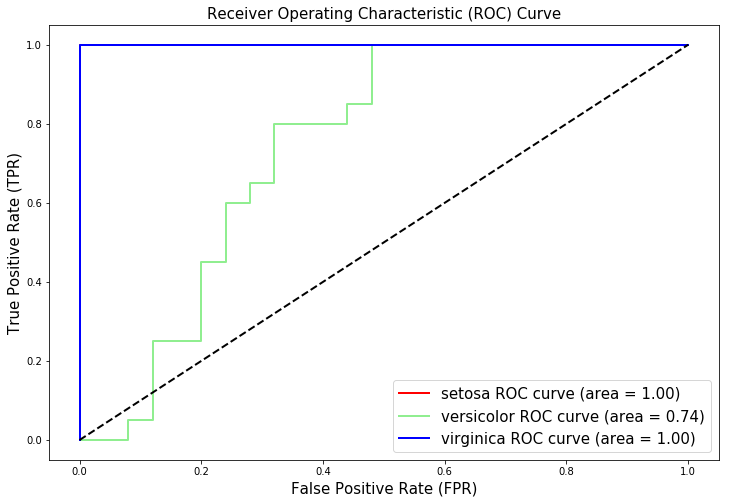

In [52]:
plt.figure(figsize=(12,8))
colors = ['red','lightgreen','blue']
for i in range(len(y.unique())):
    plt.plot(FPR[i], TPR[i], color=colors[i], lw=2, label='%s ROC curve (area = %0.2f)' % (y.unique()[i],AUC[i]))

plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=15)
plt.ylabel('True Positive Rate (TPR)', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc=4, fontsize=15)

Each point on the ROC curve represents a TPR/FPR pair that correspond to a particular decision threshold. The best possible curve is one that passes through the top left corner with 100% TPR, and 0% FPR, with AUC = 1. This can be seen in both the Setosa, and Viriginica classes. The black dashed line represents the worst possible model. It is equivalent to randomly assigning TP/FP. 

This is useful for evaluating multiple models against one another, either directly are at various TPR/FPR thresholds. The AUC can be seen as a summary of the model's ability like the F1-score. 

## Decision Boundary w/ PCA
The decision boundary is where the model switches from predicting one class to another. For visual representation purposes, we will again use the principal components we computed above for training. This way we can train a model with 2 features, and visualize the decision boundary in 2D space.

We will follow the same steps as above for training a model. We use use the coded y as the contour plot that we use below prefers numerical values.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x_pca,y.cat.codes,test_size=0.3, random_state=101)

In [54]:
model = LogisticRegression()
model.fit(X_train,y_train)

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [55]:
predictions = model.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(predictions,y_test)*100))

Accuracy: 88.89%


### Plotting
We will first generate a grid of x[0] and x[1] values that we will use to make predictions with.

In [56]:
x_min = x_pca[:,0].min()
x_max = x_pca[:,0].max()
y_min = x_pca[:,1].min()
y_max = x_pca[:,1].max()
spacing = 0.01

In [57]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, spacing), np.arange(y_min, y_max, spacing))

Now we will make predictions on the grid that we created. The `ravel` function just makes the 2D array that we have above into a 1D array. We will reshape the predictions Z into a 2D array afterwards for plotting

In [58]:
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Now we will plot the data, and the decision boundaries.

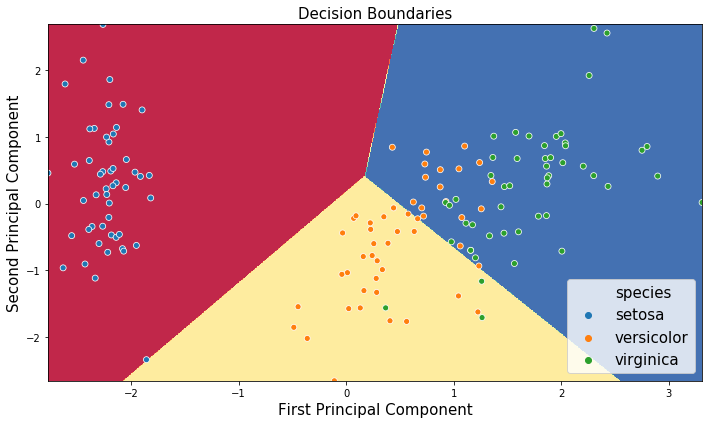

In [59]:
plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=irisDF['species'], cmap=plt.cm.Spectral)
plt.title('Decision Boundaries', fontsize=15)
plt.xlabel('First Principal Component', fontsize=15)
plt.ylabel('Second Principal Component', fontsize=15)
plt.tight_layout()
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.legend(fontsize=15)

From the above you can see the decision splits. Setosa is well classified by its splits, but there are few false virginca predictions, and more false versicolor predictions.